In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
# from efficientnet_pytorch import EfficientNet
a = torch.Tensor([1]).cuda()
print(a)

tensor([1.], device='cuda:0')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('ggplot')
from PIL import Image, ImageDraw
from tqdm import tqdm

In [3]:
train_sample_metadata = pd.read_json('./input/train_sample_videos/metadata.json').T
train_sample_metadata.head()
train_sample_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, aagfhgtpmv.mp4 to eukvucdetx.mp4
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     400 non-null    object
 1   split     400 non-null    object
 2   original  323 non-null    object
dtypes: object(3)
memory usage: 28.7+ KB


In [4]:
input_dir = './output/deepfake-detection-challenge/train_sample_videos/'
real_dirs = []
fake_dirs = []
for i in range(len(train_sample_metadata)):
    fn = train_sample_metadata.index[i]
    label = train_sample_metadata.iloc[i,0]
    fn_dir = input_dir+fn+'/'
    if label=='REAL':
        real_dirs.append(fn_dir)
    else:
        fake_dirs.append(fn_dir)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, real_dirs, fake_dirs, transform=None):
        self.image_list = []
        self.label_list = []
        self.transform = transform
        
        for directory in real_dirs:
            if not os.path.exists(directory):
                continue
            for filename in os.listdir(directory):
                if filename.endswith('.jpg'):
                    self.image_list.append(os.path.join(directory, filename))
                    self.label_list.append(0)
                    
        for directory in fake_dirs:
            if not os.path.exists(directory):
                continue
            for filename in os.listdir(directory):
                if filename.endswith('.jpg'):
                    self.image_list.append(os.path.join(directory, filename))
                    self.label_list.append(1)
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_list[index]).convert('RGB')
        image = image.resize((224, 224))
        label = self.label_list[index]
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
train_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_data = CustomDataset(real_dirs, fake_dirs, transform=train_transforms)
# from sklearn.model_selection import train_test_split
# train_data, test_data = train_test_split(train_dataset, test_size=0.2)

In [8]:
test_sample_metadata = pd.read_json('./input/dfdc_train_part_0/metadata.json').T
test_sample_metadata.head()
test_sample_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1334 entries, owxbbpjpch.mp4 to etychryvty.mp4
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     1334 non-null   object
 1   split     1334 non-null   object
 2   original  1248 non-null   object
dtypes: object(3)
memory usage: 74.0+ KB


In [9]:
input_dir = './output/deepfake-detection-challenge/dfdc_train_part_0/'
real_dirs_t = []
fake_dirs_t = []
for i in range(len(test_sample_metadata)):
    fn = test_sample_metadata.index[i]
    label = test_sample_metadata.iloc[i,0]
    fn_dir = input_dir+fn+'/'
    if label=='REAL':
        real_dirs_t.append(fn_dir)
    else:
        fake_dirs_t.append(fn_dir)

In [10]:
test_data = CustomDataset(real_dirs_t, fake_dirs_t, transform=train_transforms)
print(len(test_data))
# from sklearn.model_selection import train_test_split
# train_data, test_data = train_test_split(train_dataset, test_size=0.2)

23179


In [11]:
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
# model = EfficientNet.from_pretrained('efficientnet-b0')
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 52 * 52, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = MyModel()

In [13]:
def display_model(model):
    # Check number of parameters 
    summary_dict = {}
    num_params = 0
    summary_str = ['='*80]

    for module_name, module in model.named_children():
        summary_count = 0
        for name, param in module.named_parameters():
            if(param.requires_grad):
                summary_count += param.numel()
                num_params += param.numel()
        summary_dict[module_name] = [summary_count]
        summary_str+= [f'- {module_name: <40} : {str(summary_count):^34s}']

    summary_dict['total'] = [num_params]

    # print summary string
    summary_str += ['='*80]
    summary_str += ['--' +  f'{"Total":<40} : {str(num_params) + " params":^34s}' +'--']
    print('\n'.join(summary_str))

    # print model structure
    print(model)

In [14]:
# model._fc = torch.nn.Linear(1280, 1)

In [15]:
# for param in model.parameters():
#     param.requires_grad = False
# for param in model._fc.parameters():
#     param.requires_grad = True

In [16]:
display_model(model)
# model.compile(loss="binary_crossentropy", optimizer="nadam",
#               metrics=["accuracy"])
# model.summary()

- conv1                                    :                9472               
- pool1                                    :                 0                 
- conv2                                    :               73856               
- conv3                                    :               147584              
- pool2                                    :                 0                 
- flatten                                  :                 0                 
- fc1                                      :              44302464             
- dropout1                                 :                 0                 
- fc2                                      :                8256               
- dropout2                                 :                 0                 
- fc3                                      :                 65                
--Total                                    :          44541697 params          --
MyModel(
  (conv1): Conv2d(3, 64, kern

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []
    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (images, labels) in it_train:
        # TO DO: read/understand and then uncomment these lines
        images, labels = images.to(device), labels.view(-1, 1).to(device).float()
        optimizer.zero_grad()
        prediction = model(images)
        loss = criterion(prediction, labels)
        it_train.set_description(f'loss: {loss:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
             precision: precision score of predicted labels
             recall: recall score of predicted labels
             f1: f1 score of predicted labels
    """
    model.eval()
    losses = []
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (images, labels) in it_test:
        images, labels = images.to(device), labels.view(-1, 1).to(device).float()
        with torch.no_grad():
            output = model(images)
            preds = torch.round(torch.sigmoid(output)).type(torch.int)
            loss = criterion(output, labels)
            losses.append(loss.item())
            predicted_labels.extend(preds.cpu().detach().numpy())
            true_labels.extend(labels.cpu().detach().numpy())
            correct += (preds == labels).sum().item()
            total += len(labels)
    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))
    print('Precision: {0:.4f}'.format(precision))
    print('Recall: {0:.4f}'.format(recall))
    print('F1 Score: {0:.4f}'.format(f1))

    return mean_accuracy, test_loss, precision, recall, f1

In [18]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [19]:
train_losses = []
train_accuracy_list = []
test_losses = []
test_accuracy_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_interval = 5

# Iterate over the DataLoader for training data
for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1):
    train_loss = train(train_loader, model, criterion, optimizer) # Train the Network for one epoch
    # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
    scheduler.step()
    train_losses.append(train_loss)
    print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')

    if(epoch%test_interval==0 or epoch==1 or epoch==num_epochs-1):
        print('Evaluating Network')

        train_accuracy, _, _, _, _ = test(train_loader, model, criterion)
        train_accuracy_list.append(train_accuracy)

        print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

        test_accuracy, test_loss, test_precision, test_recall, test_f1 = test(test_loader, model, criterion)
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        test_precision_list.append(test_precision)
        test_recall_list.append(test_recall)
        test_f1_list.append(test_f1)

        print(f'Testing accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')


loss: 0.446: 100%|██████████| 336/336 [00:32<00:00, 10.26it/s]


Loss for Training on epoch 0 is 1.5703837871551514 

Evaluating Network


Validating ...: 100%|██████████| 336/336 [00:35<00:00,  9.46it/s]


Mean Accuracy: 0.8255
Avg loss: 0.41243777907497825
Precision: 0.8298
Recall: 0.9826
F1 Score: 0.8998
Training accuracy on epoch 0 is 0.8254589507035691 



Validating ...: 100%|██████████| 725/725 [01:16<00:00,  9.51it/s]

Training ...:  20%|██        | 1/5 [02:24<09:39, 144.87s/it]

Mean Accuracy: 0.9166
Avg loss: 0.3531569082315626
Precision: 0.9200
Recall: 0.9959
F1 Score: 0.9564
Testing accuracy on epoch 0 is 0.9166055481254584 



loss: 0.342: 100%|██████████| 336/336 [00:33<00:00,  9.98it/s]


Loss for Training on epoch 1 is 0.541120707988739 

Evaluating Network


Validating ...: 100%|██████████| 336/336 [00:36<00:00,  9.18it/s]


Mean Accuracy: 0.8518
Avg loss: 0.3469792001747659
Precision: 0.8599
Recall: 0.9727
F1 Score: 0.9128
Training accuracy on epoch 1 is 0.8518311434162706 



Validating ...: 100%|██████████| 725/725 [01:18<00:00,  9.29it/s]

Training ...:  40%|████      | 2/5 [04:53<07:21, 147.14s/it]

Mean Accuracy: 0.8800
Avg loss: 0.399455474242568
Precision: 0.9221
Recall: 0.9496
F1 Score: 0.9357
Testing accuracy on epoch 1 is 0.8799775659001683 



loss: 0.212: 100%|██████████| 336/336 [00:33<00:00,  9.99it/s]

Training ...:  60%|██████    | 3/5 [05:27<03:10, 95.33s/it] 

Loss for Training on epoch 2 is 0.45664098858833313 



loss: 0.247: 100%|██████████| 336/336 [00:33<00:00,  9.91it/s]

Training ...:  80%|████████  | 4/5 [06:01<01:11, 71.10s/it]

Loss for Training on epoch 3 is 0.39330193400382996 



loss: 0.044: 100%|██████████| 336/336 [00:34<00:00,  9.62it/s]


Loss for Training on epoch 4 is 0.3234703838825226 

Evaluating Network


Validating ...: 100%|██████████| 336/336 [00:38<00:00,  8.72it/s]


Mean Accuracy: 0.9034
Avg loss: 0.23938024152691165
Precision: 0.9056
Recall: 0.9811
F1 Score: 0.9418
Training accuracy on epoch 4 is 0.9033640853601714 



Validating ...: 100%|██████████| 725/725 [01:25<00:00,  8.51it/s]

Training ...: 100%|██████████| 5/5 [08:40<00:00, 104.06s/it]

Mean Accuracy: 0.7947
Avg loss: 0.4722966832641898
Precision: 0.9183
Recall: 0.8526
F1 Score: 0.8842
Testing accuracy on epoch 4 is 0.7946848440398637 



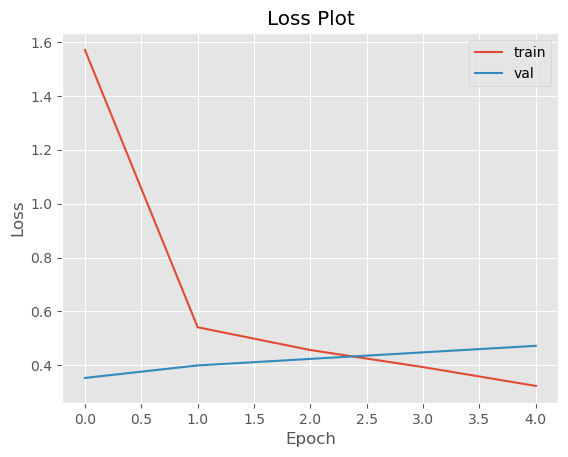

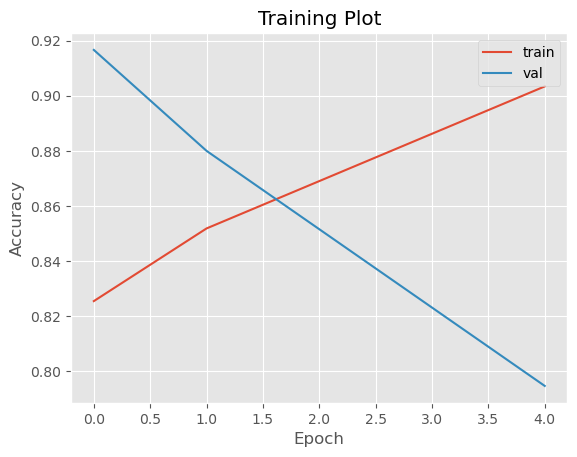

In [20]:
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_accuracy(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Training Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
plot_losses(train_losses, test_losses, test_interval, num_epochs)
plot_accuracy(train_accuracy_list, test_accuracy_list, test_interval, num_epochs)

In [21]:
import random
def eval_example(model, dirs):
    model.eval()
    image_path = random.choice(dirs)+'0.jpg'
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.show()
    image = image.resize((224, 224))
    image = train_transforms(image).unsqueeze(0).to(device)
    output = model(image)
    pred = torch.sigmoid(output).item()
    print(output.item())
    if pred>0.5:
        print('Prediction: FAKE')
    else:
        print('Prediction: REAL')

In [22]:
f = eval_example(model, fake_dirs_t)

FileNotFoundError: [Errno 2] No such file or directory: './output/deepfake-detection-challenge/dfdc_train_part_0/qrkjzekzkc.mp4/0.jpg'

In [ ]:
r = eval_example(model, real_dirs_t)